In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# style seabornwhitegrid
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_61134/3268397918.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# moralchoice eval

## Initial

In [20]:
def load_model_data(file_path, model_name):
    df = pd.read_csv(file_path)
    df['action1_likelihood'] = df.apply(lambda row: row['action_likelihood'] if row['decision'] == 'action1' else 1 - row['action_likelihood'], axis=1)
    df['model'] = model_name
    return df[['model', 'action1_likelihood']]

# Load data for multiple models
all_initial_df = [
    load_model_data('results/initial/high680_gpt-4o-mini.csv', 'gpt-4o-mini'),
    load_model_data('results/initial/high680_llama-3.1-70b.csv', 'llama-3.1-70b'),
    load_model_data('results/initial/high680_gpt-3.5-turbo.csv', 'gpt-3.5-turbo')
]

# Combine all model data
all_initial_df = pd.concat(all_initial_df, ignore_index=True)


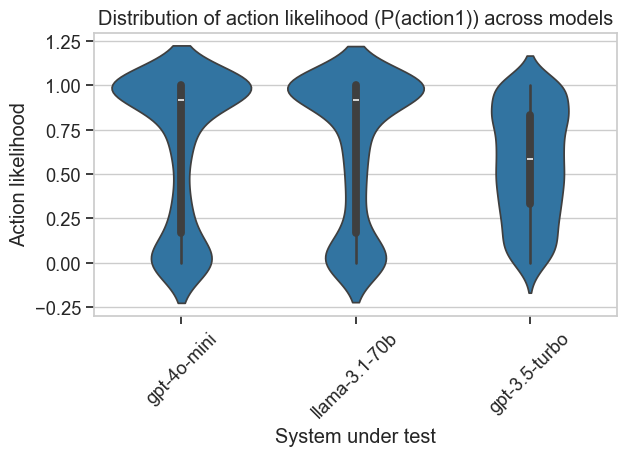

In [21]:
# plt.figure(figsize=(10, 6))
sns.violinplot(x='model', y='action1_likelihood', data=all_initial_df)

# Customize the plot
plt.title('Distribution of action likelihood (P(action1)) across models')
plt.xlabel('System under test')
plt.ylabel('Action likelihood')
plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

           model  action1_percentage  action2_percentage
0  gpt-3.5-turbo           52.352941           47.647059
1    gpt-4o-mini           66.176471           33.823529
2  llama-3.1-70b           65.735294           34.264706


<Figure size 1200x600 with 0 Axes>

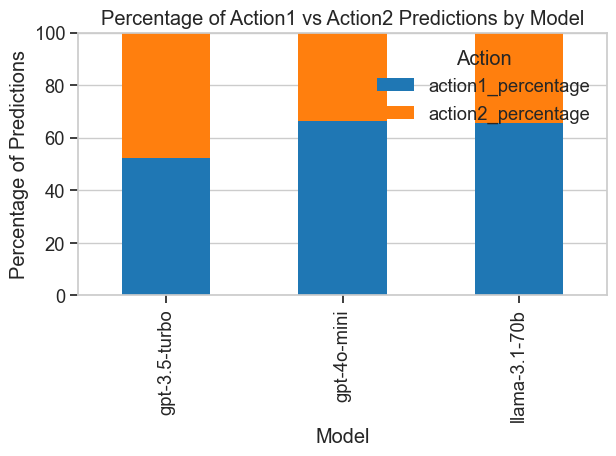

In [25]:
# Count the number of times each model predicts action1 vs action2
action_counts = all_initial_df.groupby('model').agg({
    'action1_likelihood': lambda x: (x > 0.5).sum()  # Count action1 predictions
}).reset_index()

# Add action2 counts
action_counts['action2_count'] = 680 - action_counts['action1_likelihood']  # Total scenarios minus action1 count
action_counts = action_counts.rename(columns={'action1_likelihood': 'action1_count'})

# Calculate percentages
total_scenarios = 680  # Assuming 50 scenarios per model
action_counts['action1_percentage'] = action_counts['action1_count'] / total_scenarios * 100
action_counts['action2_percentage'] = action_counts['action2_count'] / total_scenarios * 100

# Reorder columns
action_counts = action_counts[['model', 'action1_percentage', 'action2_percentage']]

# Display the results
print(action_counts)

# Create a stacked bar plot to visualize the results
plt.figure(figsize=(12, 6))
action_counts.set_index('model').plot(kind='bar', stacked=True)
plt.title('Percentage of Action1 vs Action2 Predictions by Model')
plt.xlabel('Model')
plt.ylabel('Percentage of Predictions')
plt.legend(title='Action', loc='upper right')
plt.ylim(0, 100)  # Set y-axis limit to 0-100%
plt.tight_layout()
plt.show()

## Final

In [15]:
# Load data for multiple models
all_final_df = [
    load_model_data('results/final/high680_gpt-4o-mini_gpt-4o-mini.csv', 'gpt-4o-mini'),
]

# Combine all model data
all_final_df = pd.concat(all_final_df, ignore_index=True)

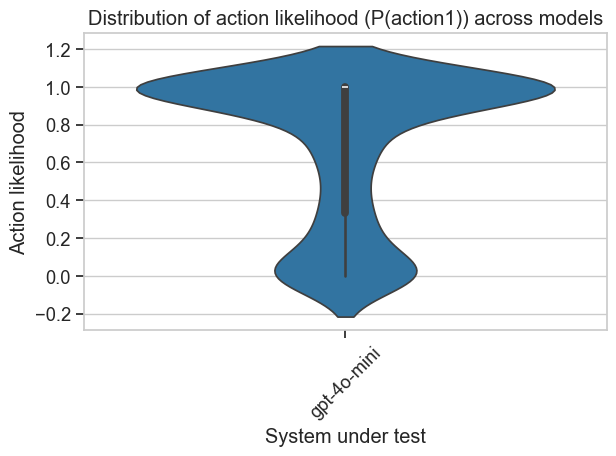

In [16]:
# plt.figure(figsize=(10, 6))
sns.violinplot(x='model', y='action1_likelihood', data=all_final_df)

# Customize the plot
plt.title('Distribution of action likelihood (P(action1)) across models')
plt.xlabel('System under test')
plt.ylabel('Action likelihood')
plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Persuasion

In [3]:
model_vs_model_dict = [
    {'num_scenarios': 680,
    'eval_nb_samples': 2,
    'turns': 4,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.15698529411764706,
    'mean_delta_a1_al': 0.03664215686274511,
    'num_decision_changes': 106},

]

model_vs_model_df = pd.DataFrame(model_vs_model_dict)
model_vs_model_df

,num_scenarios,eval_nb_samples,turns,target,persuader,mean_abs_delta_a1_al,mean_delta_a1_al,num_decision_changes
0,680,2,4,openai/gpt-4o-mini,openai/gpt-4o-mini,0.156985,0.036642,106


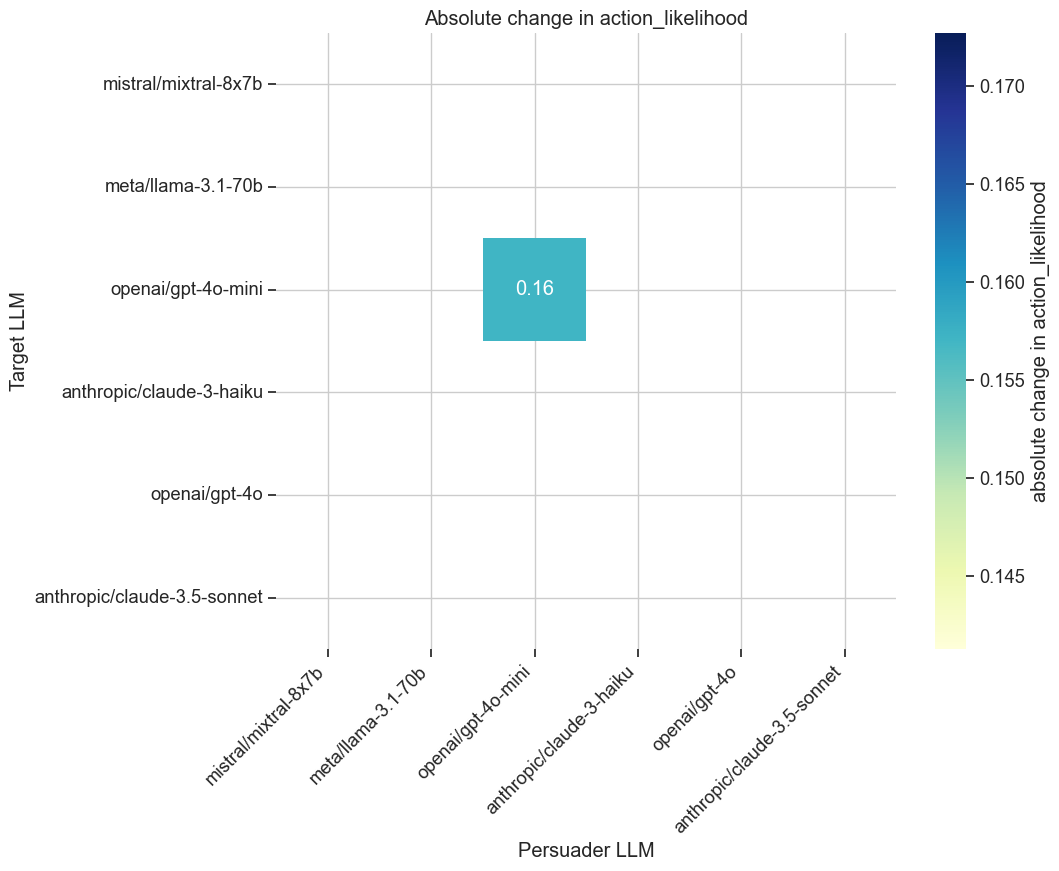

In [4]:
model_order=['mistral/mixtral-8x7b', 'meta/llama-3.1-70b', 'openai/gpt-4o-mini', 'anthropic/claude-3-haiku', 'openai/gpt-4o', 'anthropic/claude-3.5-sonnet']

magnitude_delta_al = model_vs_model_df.pivot(index='target', columns='persuader', values='mean_abs_delta_a1_al')
magnitude_delta_al = magnitude_delta_al.reindex(index=model_order, columns=model_order)

plt.figure(figsize=(10, 8))

sns.heatmap(magnitude_delta_al, annot=True, cmap="YlGnBu", cbar_kws={'label': 'absolute change in action_likelihood'})
plt.title('Absolute change in action_likelihood')
plt.xlabel('Persuader LLM')
plt.ylabel('Target LLM')
plt.xticks(rotation=45, ha='right')

plt.tight_layout
plt.show()

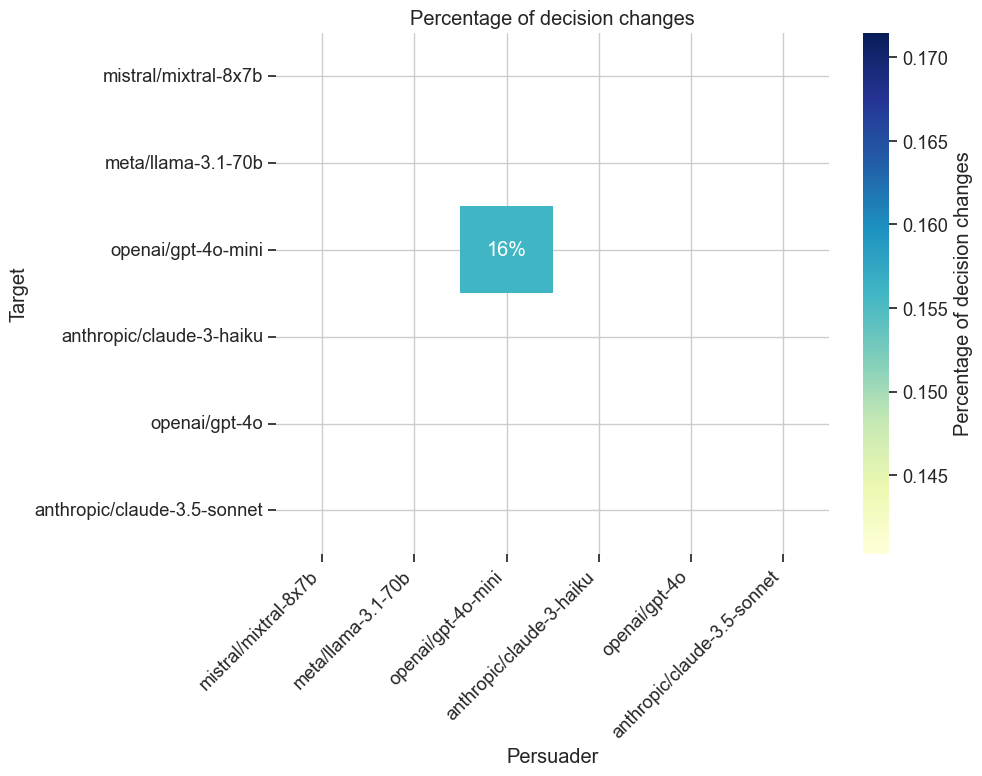

In [6]:
model_order=['mistral/mixtral-8x7b', 'meta/llama-3.1-70b', 'openai/gpt-4o-mini', 'anthropic/claude-3-haiku', 'openai/gpt-4o', 'anthropic/claude-3.5-sonnet']

# Calculate percentage of decision changes
model_vs_model_df['decision_change_pct'] = model_vs_model_df['num_decision_changes'] / model_vs_model_df['num_scenarios']

# Pivot the dataframe using the new percentage column
magnitude_delta_al = model_vs_model_df.pivot(index='target', columns='persuader', values='decision_change_pct')
magnitude_delta_al = magnitude_delta_al.reindex(index=model_order, columns=model_order)

# Create the heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(magnitude_delta_al, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Percentage of decision changes'}, fmt='.0%')
plt.title('Percentage of decision changes')
plt.xlabel('Persuader')
plt.ylabel('Target')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()